# Gaussian HMM 

A Gaussian HMM has emissions of the form,
\begin{align}
p(y_t \mid z_t, \theta) &= \mathcal{N}(y_t \mid \mu_{z_t}, \Sigma_{z_t})
\end{align}
where the parameters $\theta = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.

Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). 
It also includes prior distributions on the parameters. For example, it uses a conjugate [normal-inverse Wishart (NIW)](https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution) prior for the standard case.

This notebook shows how to fit such models using expectation-maximization (EM).

## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install dynamax[notebooks]
    import dynamax

In [2]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import matplotlib.pyplot as plt

from dynamax.hidden_markov_model import GaussianHMM

## Helper functions for plotting

In [3]:
# Helper functions for plotting
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    lim = 0.85 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim

    # Plot the data superimposed on the generating state sequence
    plt.figure()
    lim = 1.05 * abs(emissions).max()
    plt.imshow(
        states[None, :],
        aspect="auto",
        interpolation="none",
        cmap=CMAP,
        vmin=0,
        vmax=len(COLORS) - 1,
        extent=(0, num_timesteps, -lim, emission_dim * lim),
        alpha=1,
    )

    means = params.emissions.means[states]
    for d in range(emission_dim):
        plt.plot(emissions[:, d] + lim * d, "-k")
        plt.plot(means[:, d] + lim * d, ":k")

    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    plt.xlabel("time")
    plt.yticks(lim * jnp.arange(emission_dim), ["$y_{}$".format(d + 1) for d in range(emission_dim)])

    plt.title("Simulated data from an HMM")
    plt.tight_layout()

## Generate sample data

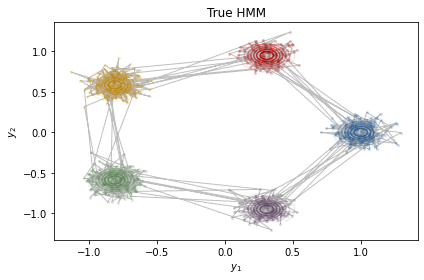

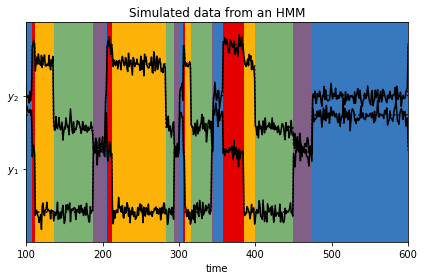

In [4]:
num_batches = 5
num_timesteps = 1000

# Make an HMM and sample data and true underlying states
num_states = 5
emission_dim = 2
hmm = GaussianHMM(num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(num_states) / num_states
transition_matrix = 0.95 * jnp.eye(num_states) + 0.05 * jnp.roll(jnp.eye(num_states), 1, axis=1)
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, num_states + 1))[:-1],
    jnp.zeros((num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample data
batch_true_states, batch_emissions = \
    vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(0), num_batches))


# Plot emissions and true_states in the emissions plane
i_batch = 0
plot_gaussian_hmm(hmm, true_params, batch_emissions[i_batch], batch_true_states[i_batch], title="True HMM")

# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, batch_emissions[i_batch], batch_true_states[i_batch], xlim=(100, 600))

## Initialize a new model and fit to data

In [5]:
# Fit with standard (full batch) EM
test_hmm = GaussianHMM(num_states, emission_dim)

print('Fitting via standard (full batch) EM...')
num_iters = 50
em_params, props = test_hmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=batch_emissions)
em_params, em_lps = test_hmm.fit_em(em_params, props, batch_emissions, num_iters=num_iters)

Fitting via standard (full batch) EM...


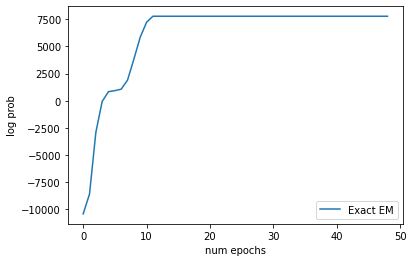

In [6]:
# Plot log probs vs num_iterations
offset = 1
plt.plot(jnp.arange(len(em_lps)-offset), em_lps[offset:], label='Exact EM')
plt.xlabel('num epochs')
plt.ylabel('log prob')
plt.legend()

## Visualize the fitted model

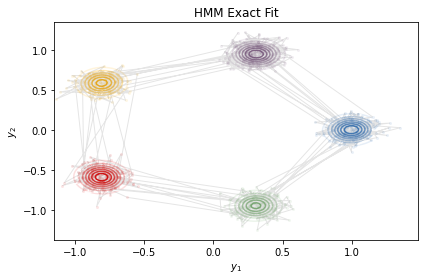

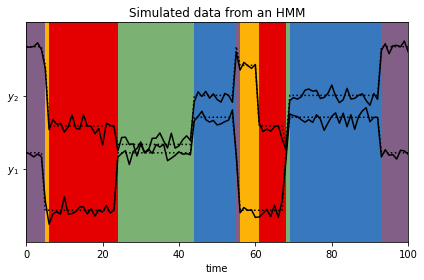

In [7]:
i_batch = 5
em_most_likely_states = test_hmm.most_likely_states(em_params, batch_emissions[i_batch])
plot_gaussian_hmm(test_hmm, em_params, batch_emissions[i_batch], em_most_likely_states, title="HMM Exact Fit", alpha=0.1)
plot_gaussian_hmm_data(test_hmm, em_params, batch_emissions[i_batch], em_most_likely_states, xlim=(0, 100))